In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
# Libraries
print("\tImporting libraries...\n")
import sys; sys.path.append("..")
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ml libraries

# dl libraries
import torch

# ext. libraries
import src.utils as utils
from src.helper import HeaParser
print("\tImport complete!\n")

utils.set_plt_style()
device = utils.get_device_info()
seed = utils.set_all_seeds()

NUM_WORKERS = 23
DATASET_NAME = "mimic-iv-ecg"
DATASET_DIR = os.path.join("..", "data", DATASET_NAME)
# OUTPUT_DIR = os.path.join("..", "out", DATASET_NAME)

	Importing libraries...



Seed set to 42



=== Environment Information ===
Python version: 3.12.2
PyTorch version: 2.6.0
NumPy version: 1.26.4
Platform: macOS-15.4.1-arm64-arm-64bit

	Import complete!


=== Device Information ===
CUDA available: False
Using device: cpu


=== Setting Random Seeds ===
Seed value: 42
Setting torch CPU seed...
Setting torch CUDA seed...
Setting numpy seed...
Configuring CUDNN...
Configuring PL...



Processing data:   0%|          | 0/1921 [00:00<?, ?it/s]

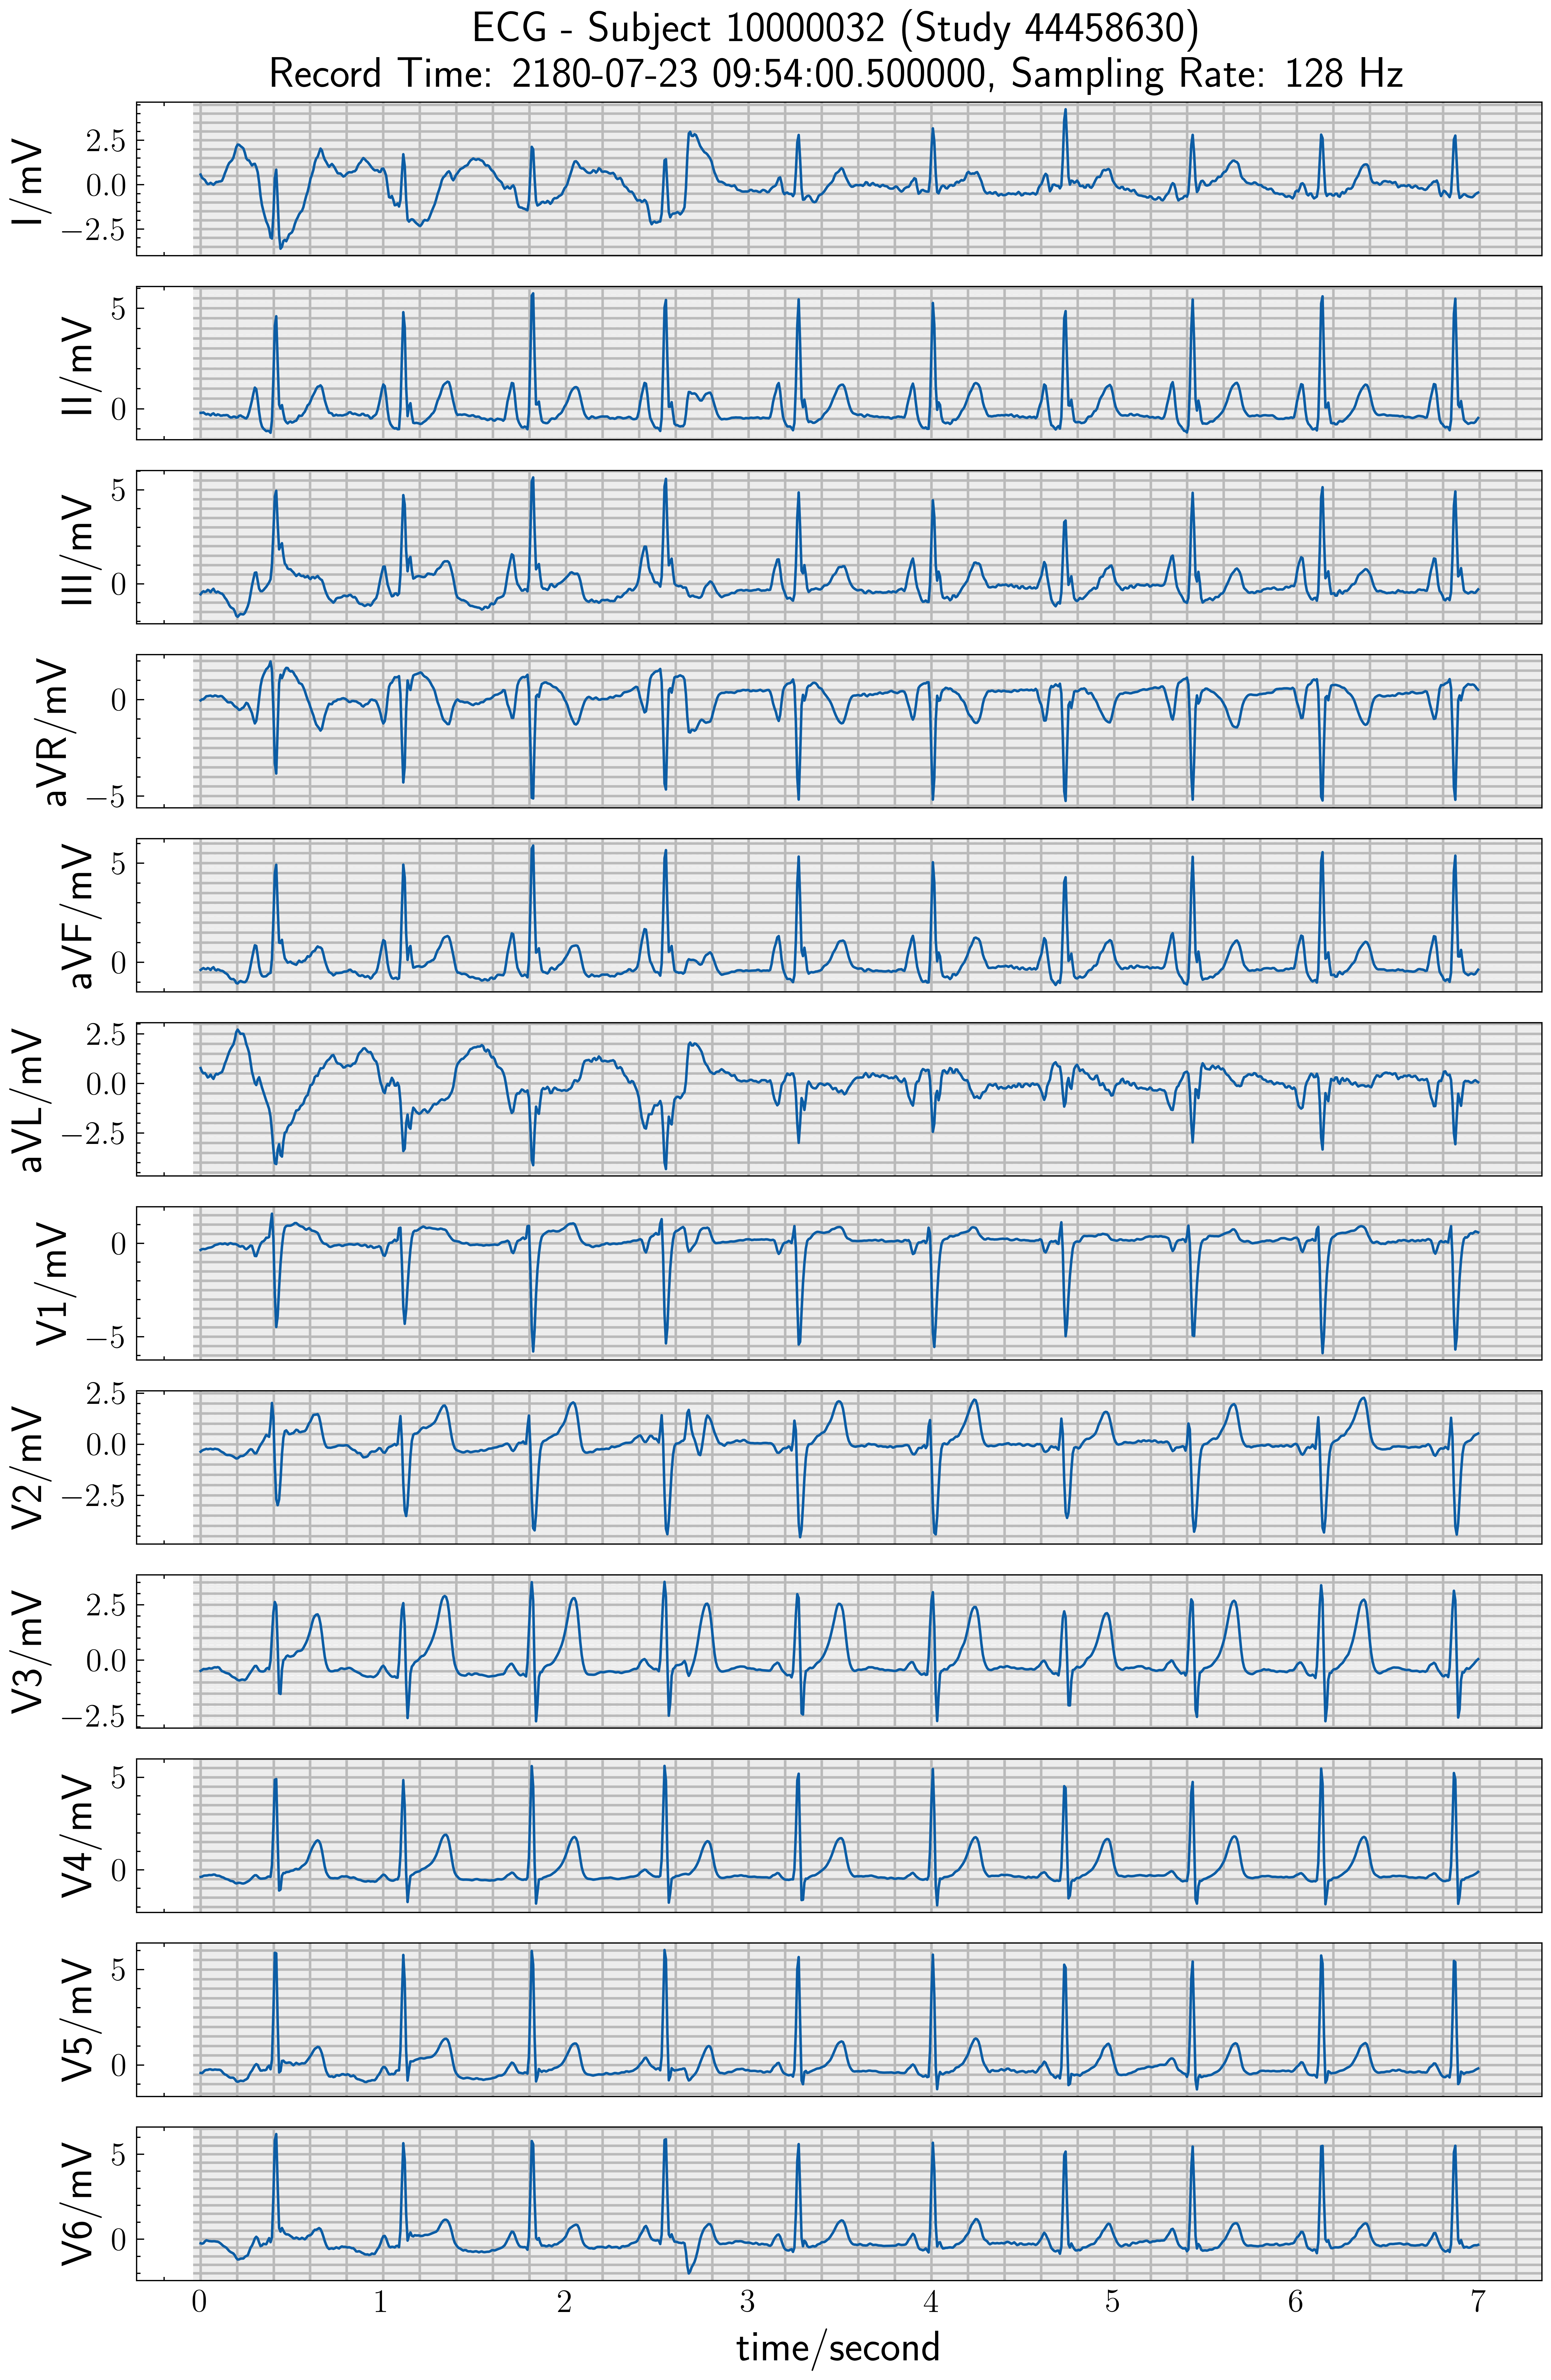

/Users/juntangwang/Library/CloudStorage/OneDrive-DukeUniversity/Documents/_Projects/ecg4kca/notebook/../src/helper.py:82: UserWarning: No peak > 2.5 found, using any peak
  warnings.warn("No peak > 2.5 found, using any peak")
/Users/juntangwang/Library/CloudStorage/OneDrive-DukeUniversity/Documents/_Projects/ecg4kca/notebook/../src/helper.py:86: UserWarning: No peaks found, aligning to chosen anchor
  warnings.warn("No peaks found, aligning to chosen anchor")


Train set size: torch.Size([1514, 12, 896]) 	 with y shape: torch.Size([1514, 2])
Test  set size: torch.Size([379, 12, 896]) 	 with y shape: torch.Size([379, 2])


In [3]:
# NOTE: change to your own path to p1000-p1007 folders
base_dir = "/Volumes/Black/Data/ecg4kca/mimic-iv-ecg/1.0/files"  

parser = HeaParser(base_dir)

# read from the excel file (record -> K and Ca)
data = pd.read_excel(os.path.join(DATASET_DIR, "data_baoliuxiaoshu.xlsx"))
X = torch.tensor([])
y = torch.tensor([])

for di in tqdm(data.to_dict(orient="records"), desc="Processing data"):
    sub, std = di["subject_id"], di["study_id"]
    k  , ca  = di["potassium"] , di["calcium"]
    p = sub == 10000032 and std == 44458630 # change to own
    signal = parser.parse(str(sub), str(std), plot=p).p_signal
    x = torch.tensor(signal, dtype=torch.float32).T # (channels, timepoints)
    kca = torch.tensor([k, ca], dtype=torch.float32)
    X = torch.cat([X, x.unsqueeze(0)], dim=0) # (N, C, T)
    y = torch.cat([y, kca.unsqueeze(0)], dim=0)
    
# clean NA data
def clean_data(X, y):
    mask = ~torch.isnan(X).any(dim=(1, 2)) & ~torch.isnan(y).any(dim=1)
    return X[mask], y[mask]

X, y = clean_data(X, y)

# train-test split (0.8)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed # fixed here
)

print(f"Train set size: {X_train.shape} \t with y shape: {y_train.shape}")
print(f"Test  set size: {X_test.shape} \t with y shape: {y_test.shape}")


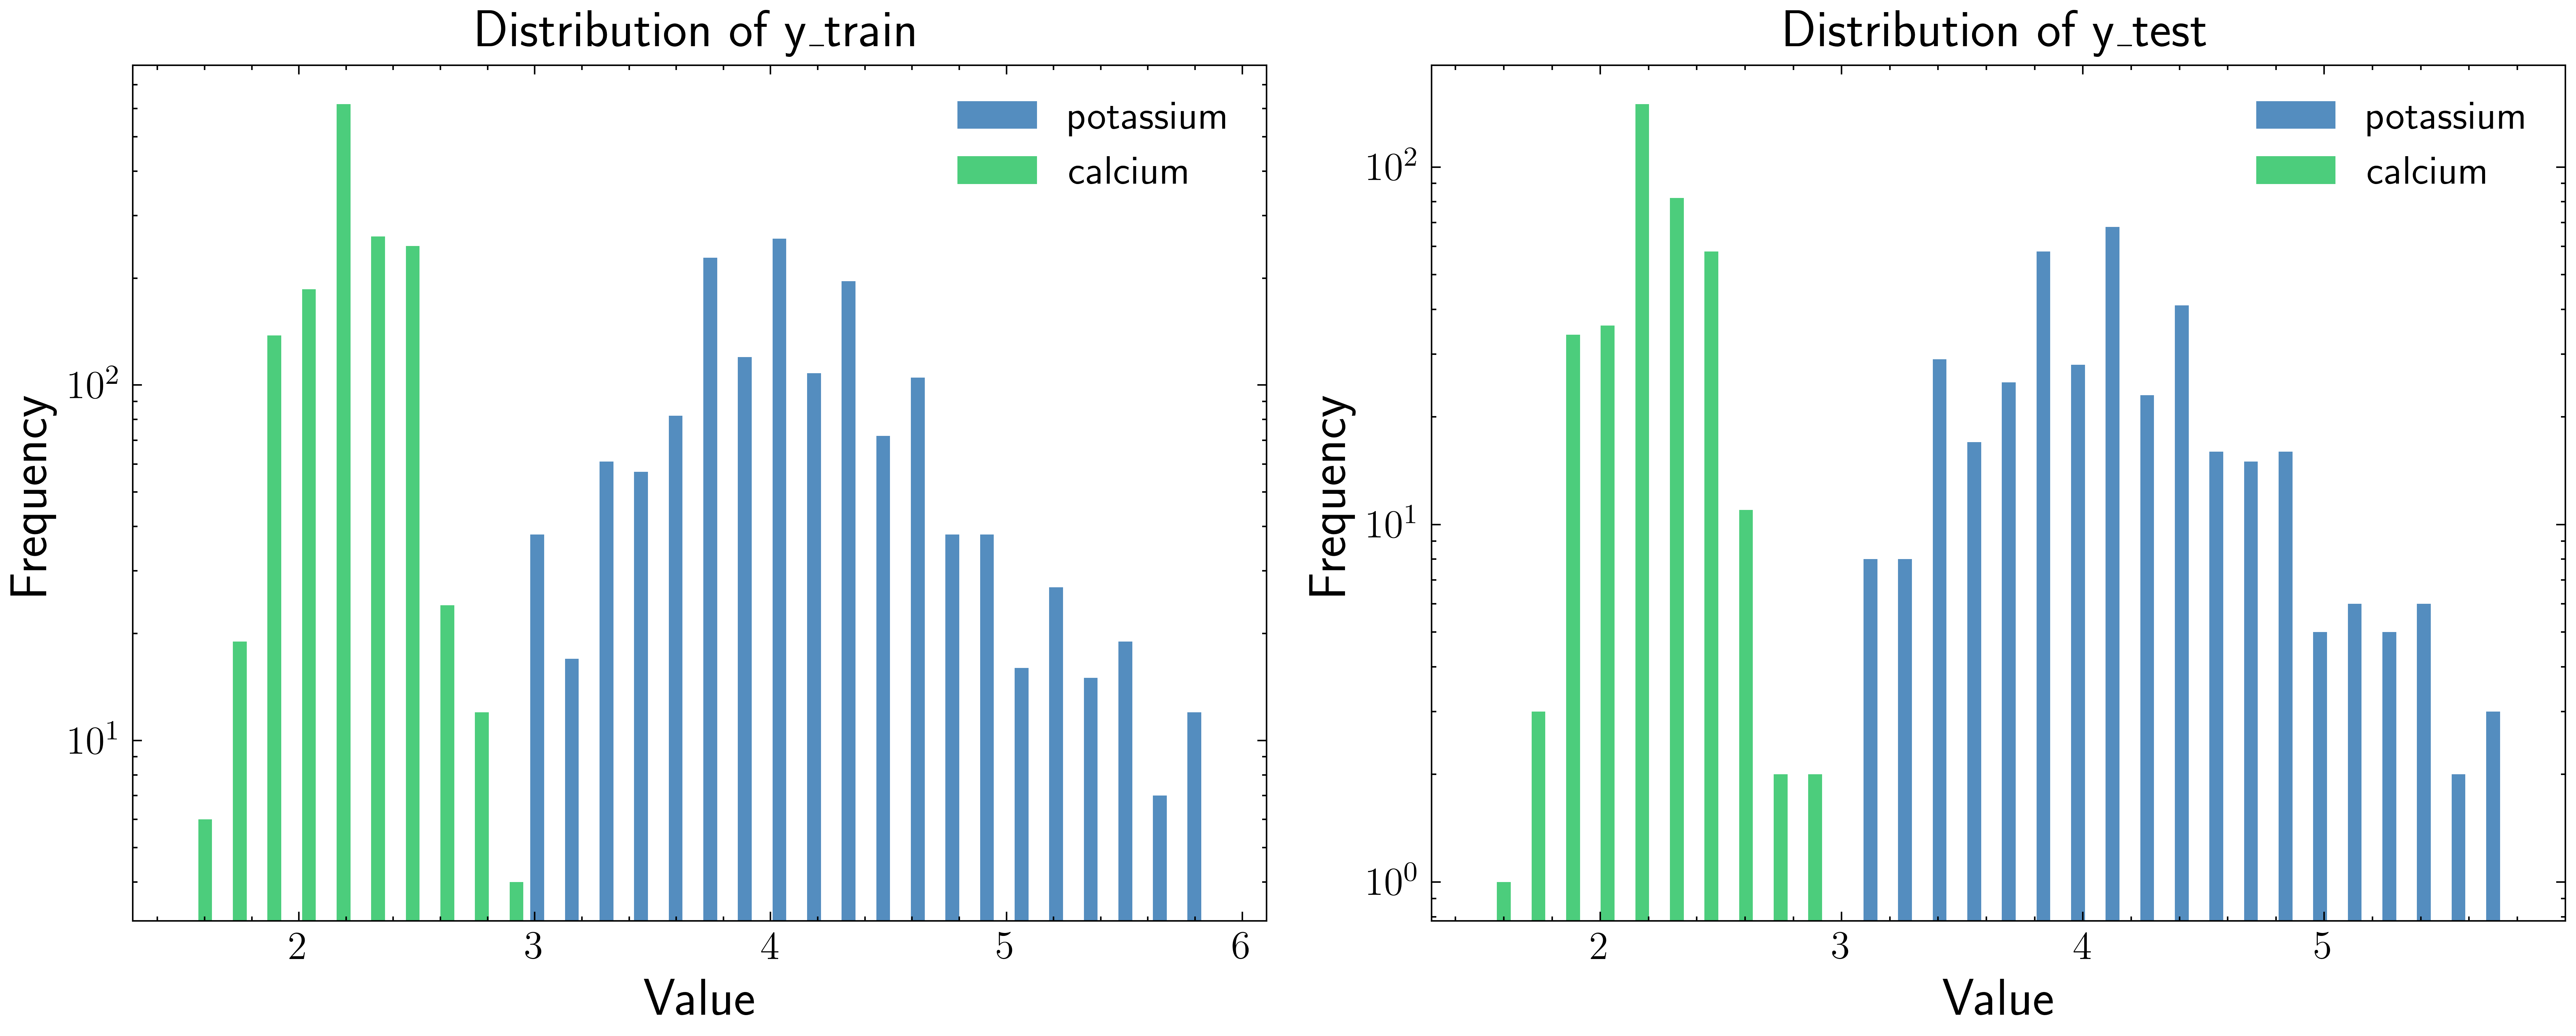

In [4]:
# Create histograms of training and test targets
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(y_train.numpy(), bins=30, alpha=0.7)
plt.title('Distribution of y_train')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(['potassium', 'calcium'])
plt.yscale('log')
plt.subplot(1,2,2)
plt.hist(y_test.numpy(), bins=30, alpha=0.7)
plt.title('Distribution of y_test')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(['potassium', 'calcium'])
plt.yscale('log')
plt.tight_layout()
plt.show()

# save as pt
torch.save((X_train, y_train, X_test, y_test),f"{DATASET_DIR}/dataset.pt")

# NOTE: example load
# X_train, y_train, X_test, y_test = torch.load(f"{DATASET_DIR}/dataset.pt")

---
# MORE
---

In [55]:
import neurokit2 as nk
import warnings

warnings.filterwarnings('ignore')

X_tr, y_tr, X_te, y_te = torch.load(f"{DATASET_DIR}/dataset.pt")

def extract_ecg_nk2(X, y, sr=128):
    rows, ys = [], []
    combined = list(zip(X, y))
    for record, yi in tqdm(combined, desc="Records"):    
        feats = {}
        try:
            for ch in range(record.shape[0]):
                sig = record[ch]
                # 1) full pipe: clean → R-peaks → delineate → intervals
                signals, info = nk.ecg_process(sig, sr)
                # 2) interval-related stats ONLY (PR, QRS, QT, QTc…)
                stats = nk.ecg_analyze(signals, sr, method="interval-related")

                for name, val in stats.items():
                    val_float = float(val.values)
                    feats[f"{name}_ch{ch+1}"] = float('nan') \
                        if np.isinf(val_float) else val_float

        except Exception as e:
            continue

        rows.append(feats)
        ys.append(yi)

    df = pd.DataFrame(rows).ffill().fillna(0)
    df = df.loc[:, (df != 0).any(axis=0)]     # Drop columns that are all zeros
    ys = torch.tensor(ys, dtype=torch.float32)
    return df, ys

df_tr, ys_tr = extract_ecg_nk2(X_tr.numpy(), y_tr.numpy(), sr=128)
df_te, ys_te = extract_ecg_nk2(X_te.numpy(), y_te.numpy(), sr=128)

print(f"Features extracted - Train: {df_tr.shape}, Test: {df_te.shape}")

Records:   0%|          | 0/1514 [00:00<?, ?it/s]

Records:   0%|          | 0/379 [00:00<?, ?it/s]

Features extracted - Train: (1396, 756), Test: (352, 756)


In [56]:
display(df_tr)
print(df_tr.columns)
df_tr.describe()

ECG_Rate_Mean_ch1  HRV_MeanNN_ch1  HRV_SDNN_ch1  HRV_RMSSD_ch1  \
0            104.579529      582.386364     57.871975      92.998288   
1             91.559879      655.381944      4.694728       6.176324   
2            110.048726      542.317708     23.896624      26.335932   
3             79.585370      753.906250      4.175957       5.114482   
4            113.663742      527.994792      6.195011       7.812500   
...                 ...             ...           ...            ...   
1391          85.418437      702.256944      4.694728       6.176324   
1392         120.385113      498.197115      3.426008       5.042947   
1393          94.984997      630.468750     37.021323      45.554312   
1394          77.476348      774.414062      5.006796       5.905695   
1395          57.277472     1048.177083      5.881036      10.481569   

      HRV_SDSD_ch1  HRV_CVNN_ch1  HRV_CVSD_ch1  HRV_MedianNN_ch1  \
0        97.247408      0.099370      0.159685         585.93750   
1         6.519711      0.007163      0.009424         656.25000   
2        26.795436      0.044064      0.048562         546.87500   
3         5.391137      0.005539      0.006784         753.90625   
4         8.159890      0.011733      0.014797         531.25000   
...            ...           ...           ...               ...   
1391      6.519711      0.006685      0.008795         703.12500   
1392      5.223109      0.006877      0.010122         500.00000   
1393     47.432306      0.058720      0.072255         628.90625   
1394      6.378880      0.006465      0.007626         773.43750   
1395     11.587810      0.005611      0.010000        1046.87500   

      HRV_MadNN_ch1  HRV_MCVNN_ch1  ...  HRV_KFD_ch12  HRV_LZC_ch12  \
0          0.000000       0.000000  ...      1.912489      0.943481   
1          0.000000       0.000000  ...      1.787766      1.408856   
2         11.582812       0.021180  ...      1.845553      1.194988   
3          5.791406       0.007682  ...      5.783271      1.875000   
4          5.791406       0.010901  ...      2.796542      1.194988   
...             ...            ...  ...           ...           ...   
1391       0.000000       0.000000  ...      1.787766      1.408856   
1392       0.000000       0.000000  ...      2.838373      1.138597   
1393      17.374219       0.027626  ...      1.239730      1.328771   
1394       0.000000       0.000000  ...      1.553295      1.125000   
1395       5.791406       0.005532  ...      1.000000      0.861654   

      HRV_MFDFA_alpha1_Width_ch12  HRV_MFDFA_alpha1_Peak_ch12  \
0                        0.360613                    0.346611   
1                        0.360613                    0.346611   
2                        0.566301                    0.925975   
3                        0.566301                    0.925975   
4                        0.360613                    0.346611   
...                           ...                         ...   
1391                     0.905462                    0.993426   
1392                     0.066697                    0.098218   
1393                     0.066697                    0.098218   
1394                     0.066697                    0.098218   
1395                     0.066697                    0.098218   

      HRV_MFDFA_alpha1_Mean_ch12  HRV_MFDFA_alpha1_Max_ch12  \
0                       0.361433                   0.605622   
1                       0.361433                   0.605622   
2                       0.978928                   0.319141   
3                       0.978928                   0.319141   
4                       0.361433                   0.605622   
...                          ...                        ...   
1391                    1.056486                   0.246487   
1392                    0.101871                   0.916712   
1393                    0.101871                   0.916712   
1394                    0.101871                   0.916712 

Index(['ECG_Rate_Mean_ch1', 'HRV_MeanNN_ch1', 'HRV_SDNN_ch1', 'HRV_RMSSD_ch1',
       'HRV_SDSD_ch1', 'HRV_CVNN_ch1', 'HRV_CVSD_ch1', 'HRV_MedianNN_ch1',
       'HRV_MadNN_ch1', 'HRV_MCVNN_ch1',
       ...
       'HRV_KFD_ch12', 'HRV_LZC_ch12', 'HRV_MFDFA_alpha1_Width_ch12',
       'HRV_MFDFA_alpha1_Peak_ch12', 'HRV_MFDFA_alpha1_Mean_ch12',
       'HRV_MFDFA_alpha1_Max_ch12', 'HRV_MFDFA_alpha1_Delta_ch12',
       'HRV_MFDFA_alpha1_Asymmetry_ch12', 'HRV_MFDFA_alpha1_Fluctuation_ch12',
       'HRV_MFDFA_alpha1_Increment_ch12'],
      dtype='object', length=756)


ECG_Rate_Mean_ch1  HRV_MeanNN_ch1  HRV_SDNN_ch1  HRV_RMSSD_ch1  \
count        1396.000000     1396.000000   1396.000000    1396.000000   
mean           84.585130      756.965737     52.960229      71.073369   
std            21.882604      184.818239     77.968329     110.202576   
min            42.931347      350.694444      2.087978       2.604167   
25%            68.398325      631.640625      6.146842       7.812500   
50%            81.868000      738.281250     16.591684      18.098403   
75%            95.424433      879.464286     69.398380      88.040827   
max           171.095854     1431.640625    822.404327    1110.605337   

       HRV_SDSD_ch1  HRV_CVNN_ch1  HRV_CVSD_ch1  HRV_MedianNN_ch1  \
count   1396.000000   1396.000000   1396.000000       1396.000000   
mean      75.778639      0.070678      0.095055        757.029011   
std      120.101919      0.098095      0.139987        190.943227   
min        2.604167      0.003315      0.003710        343.750000   
25%        8.068715      0.009078      0.011491        625.000000   
50%       18.795640      0.020704      0.022176        734.375000   
75%       93.074343      0.098397      0.130856        882.812500   
max     1270.604514      0.664569      0.897459       1429.687500   

       HRV_MadNN_ch1  HRV_MCVNN_ch1  ...  HRV_KFD_ch12  HRV_LZC_ch12  \
count    1396.000000    1396.000000  ...   1396.000000   1396.000000   
mean       37.055043       0.051213  ...      3.158205      1.390227   
std        65.886120       0.089558  ...      8.896614      0.271044   
min         0.000000       0.000000  ...    -94.576475      0.597494   
25%         5.791406       0.005548  ...      1.575330      1.203152   
50%        11.582812       0.016473  ...      2.296607      1.408856   
75%        34.748438       0.046623  ...      3.638264      1.604203   
max       689.177344       0.702284  ...    118.178545      2.005254   

       HRV_MFDFA_alpha1_Width_ch12  HRV_MFDFA_alpha1_Peak_ch12  \
count                 1.396000e+03                 1396.000000   
mean                  8.106417e-01                    0.697129   
std                   9.505988e-01                    0.564468   
min                   3.330669e-16                   -0.107018   
25%                   7.145643e-02                    0.246475   
50%                   4.494666e-01                    0.563090   
75%                   1.296779e+00                    0.993426   
max                   3.614936e+00                    2.718590   

       HRV_MFDFA_alpha1_Mean_ch12  HRV_MFDFA_alpha1_Max_ch12  \
count                 1396.000000                1396.000000   
mean                     0.733760                   0.453483   
std                      0.611317                   0.554292   
min                     -0.107018                  -1.068755   
25%                      0.243761                   0.090674   
50%                      0.591500                   0.681033   
75%                      1.032405                   0.925913   
max                      3.099291                   1.129052   

       HRV_MFDFA_alpha1_Delta_ch12  HRV_MFDFA_alpha1_Asymmetry_ch12  \
count                  1396.000000                      1396.000000   
mean                     -0.077615                        -0.489528   
std                       0.363104                         0.143077   
min                      -1.310945                        -1.000000   
25%                      -0.207966                        -0.546318   
50%                      -0.017027                        -0.462021   
75%                       0.026781                        -0.431217   
max                       1.235559                         0.000000   

       HRV_MFDFA_alpha1_Fluctuation_ch12  HRV_MFDFA_alpha1_Increment_ch12  
count                       1.396000e+03                     1.396000e+03  
mean                        1.671343e-03                     1.475328e-01  
std                         5.126319e-

In [57]:
Xf_tr = torch.tensor(df_tr.values, dtype=torch.float32)
Xf_te = torch.tensor(df_te.values, dtype=torch.float32)

Xf_tr = Xf_tr.flatten(start_dim=1)
Xf_te = Xf_te.flatten(start_dim=1)

y_k_tr, y_k_te = ys_tr[:,0], ys_te[:,0]
y_c_tr, y_c_te = ys_tr[:,1], ys_te[:,1]

In [58]:
print(ys_tr.shape)
print(y_k_tr.shape)

torch.Size([1396, 2])
torch.Size([1396])


In [59]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
Xf_tr = scaler.fit_transform(Xf_tr)
Xf_te = scaler.transform(Xf_te)

# Convert back to torch tensors
Xf_tr = torch.tensor(Xf_tr, dtype=torch.float32) 
Xf_te = torch.tensor(Xf_te, dtype=torch.float32)

	test_r2: -0.0661


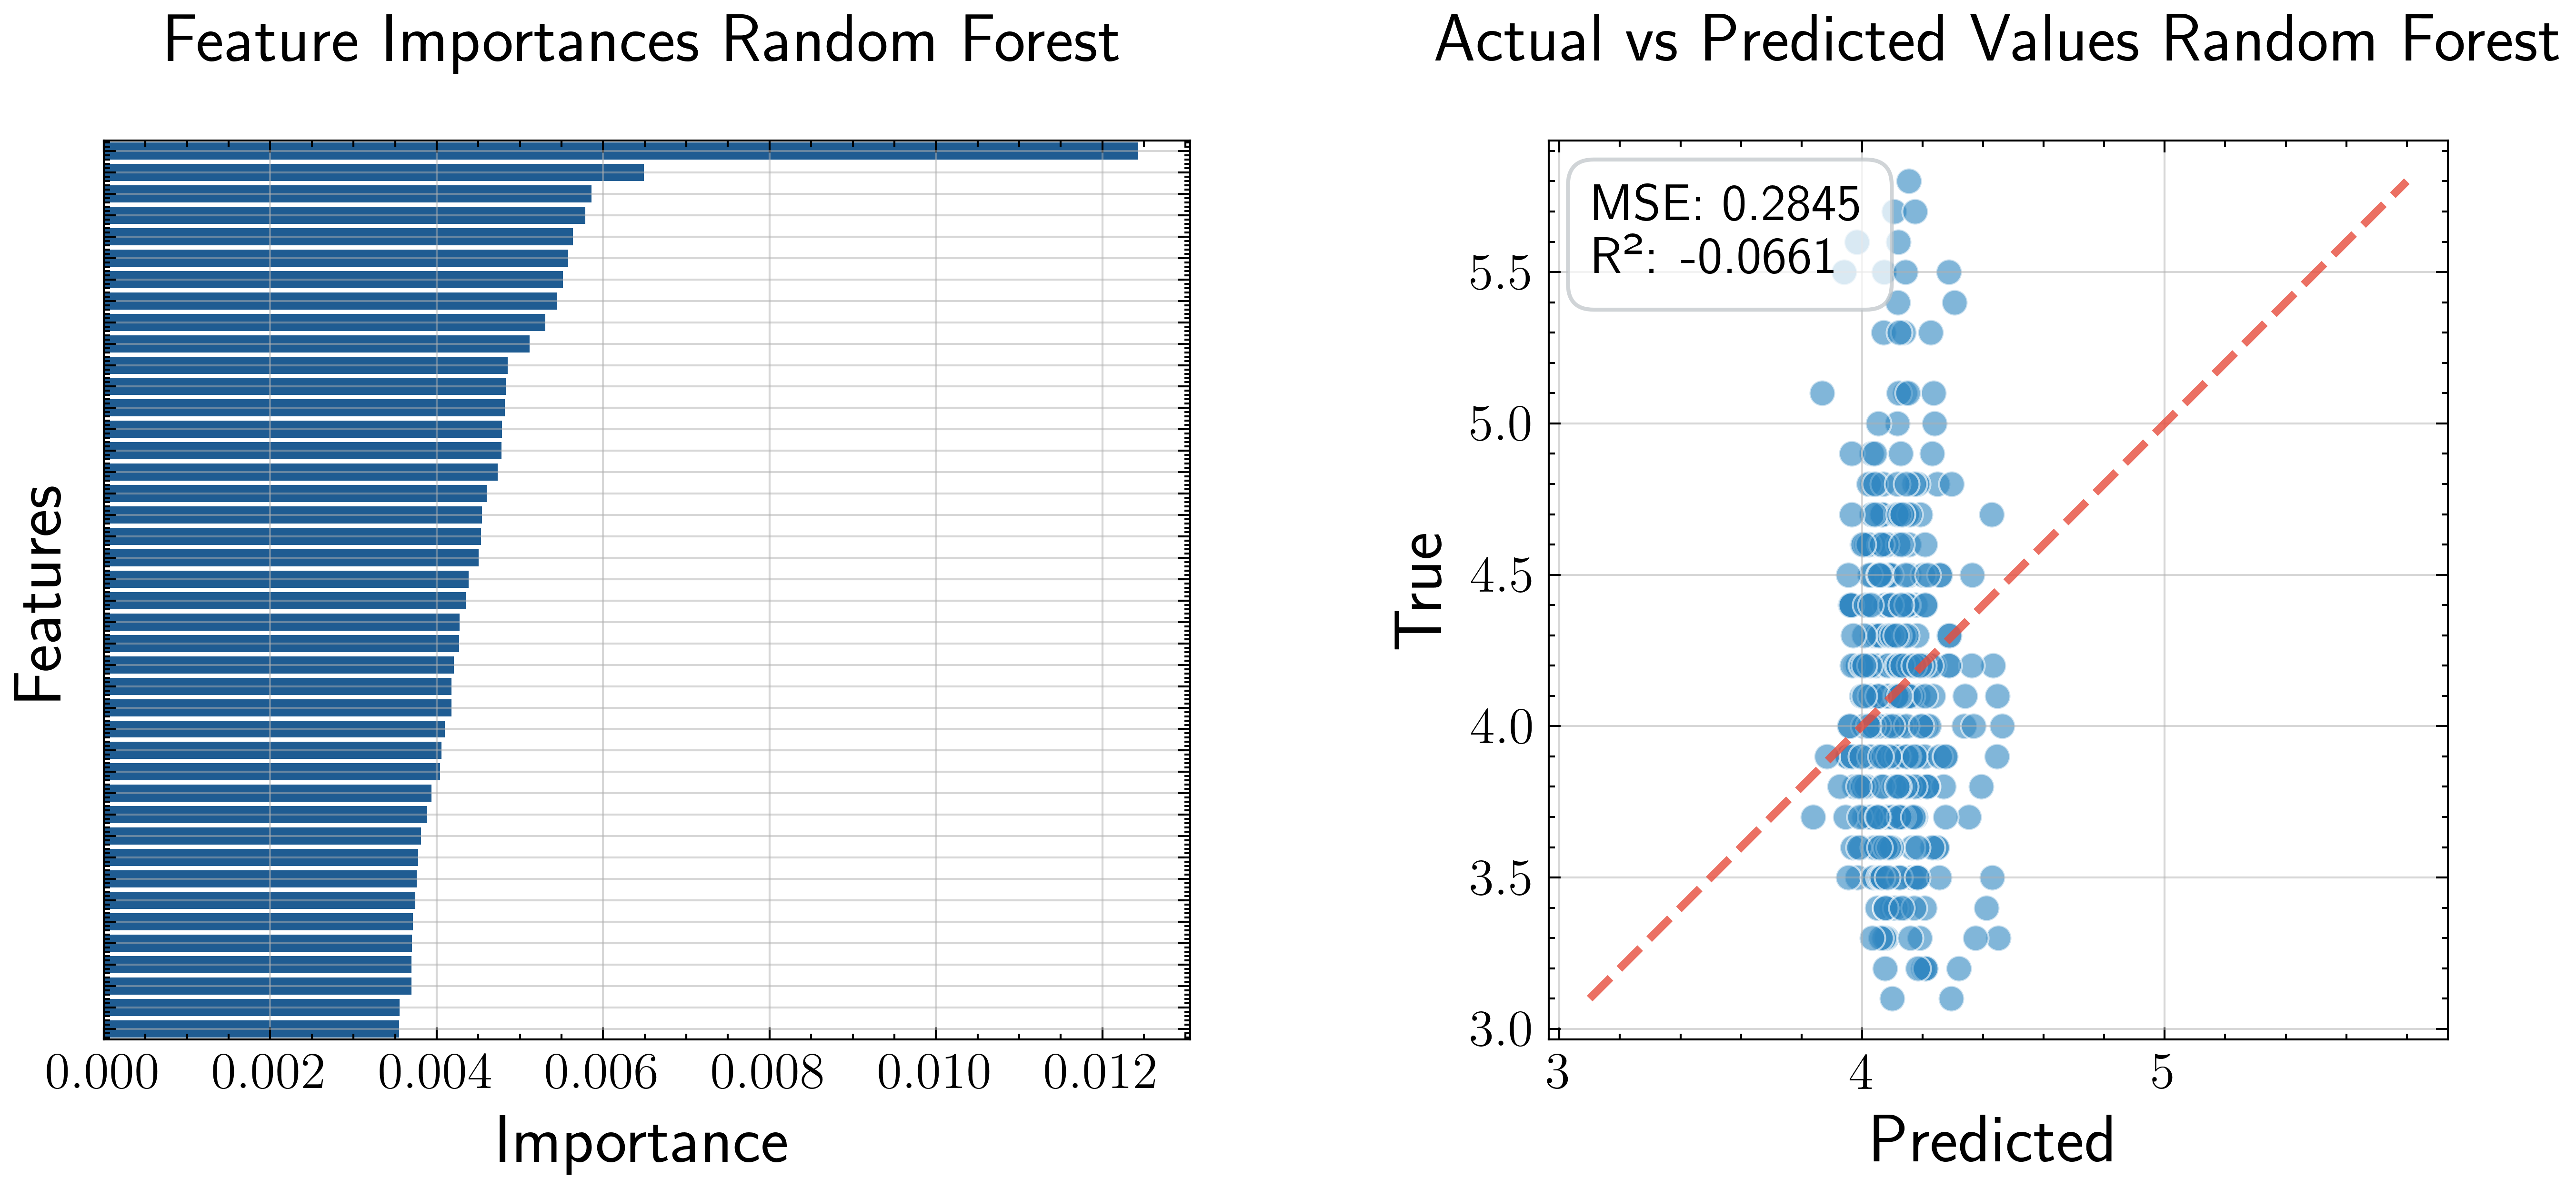

	test_r2: 0.0050


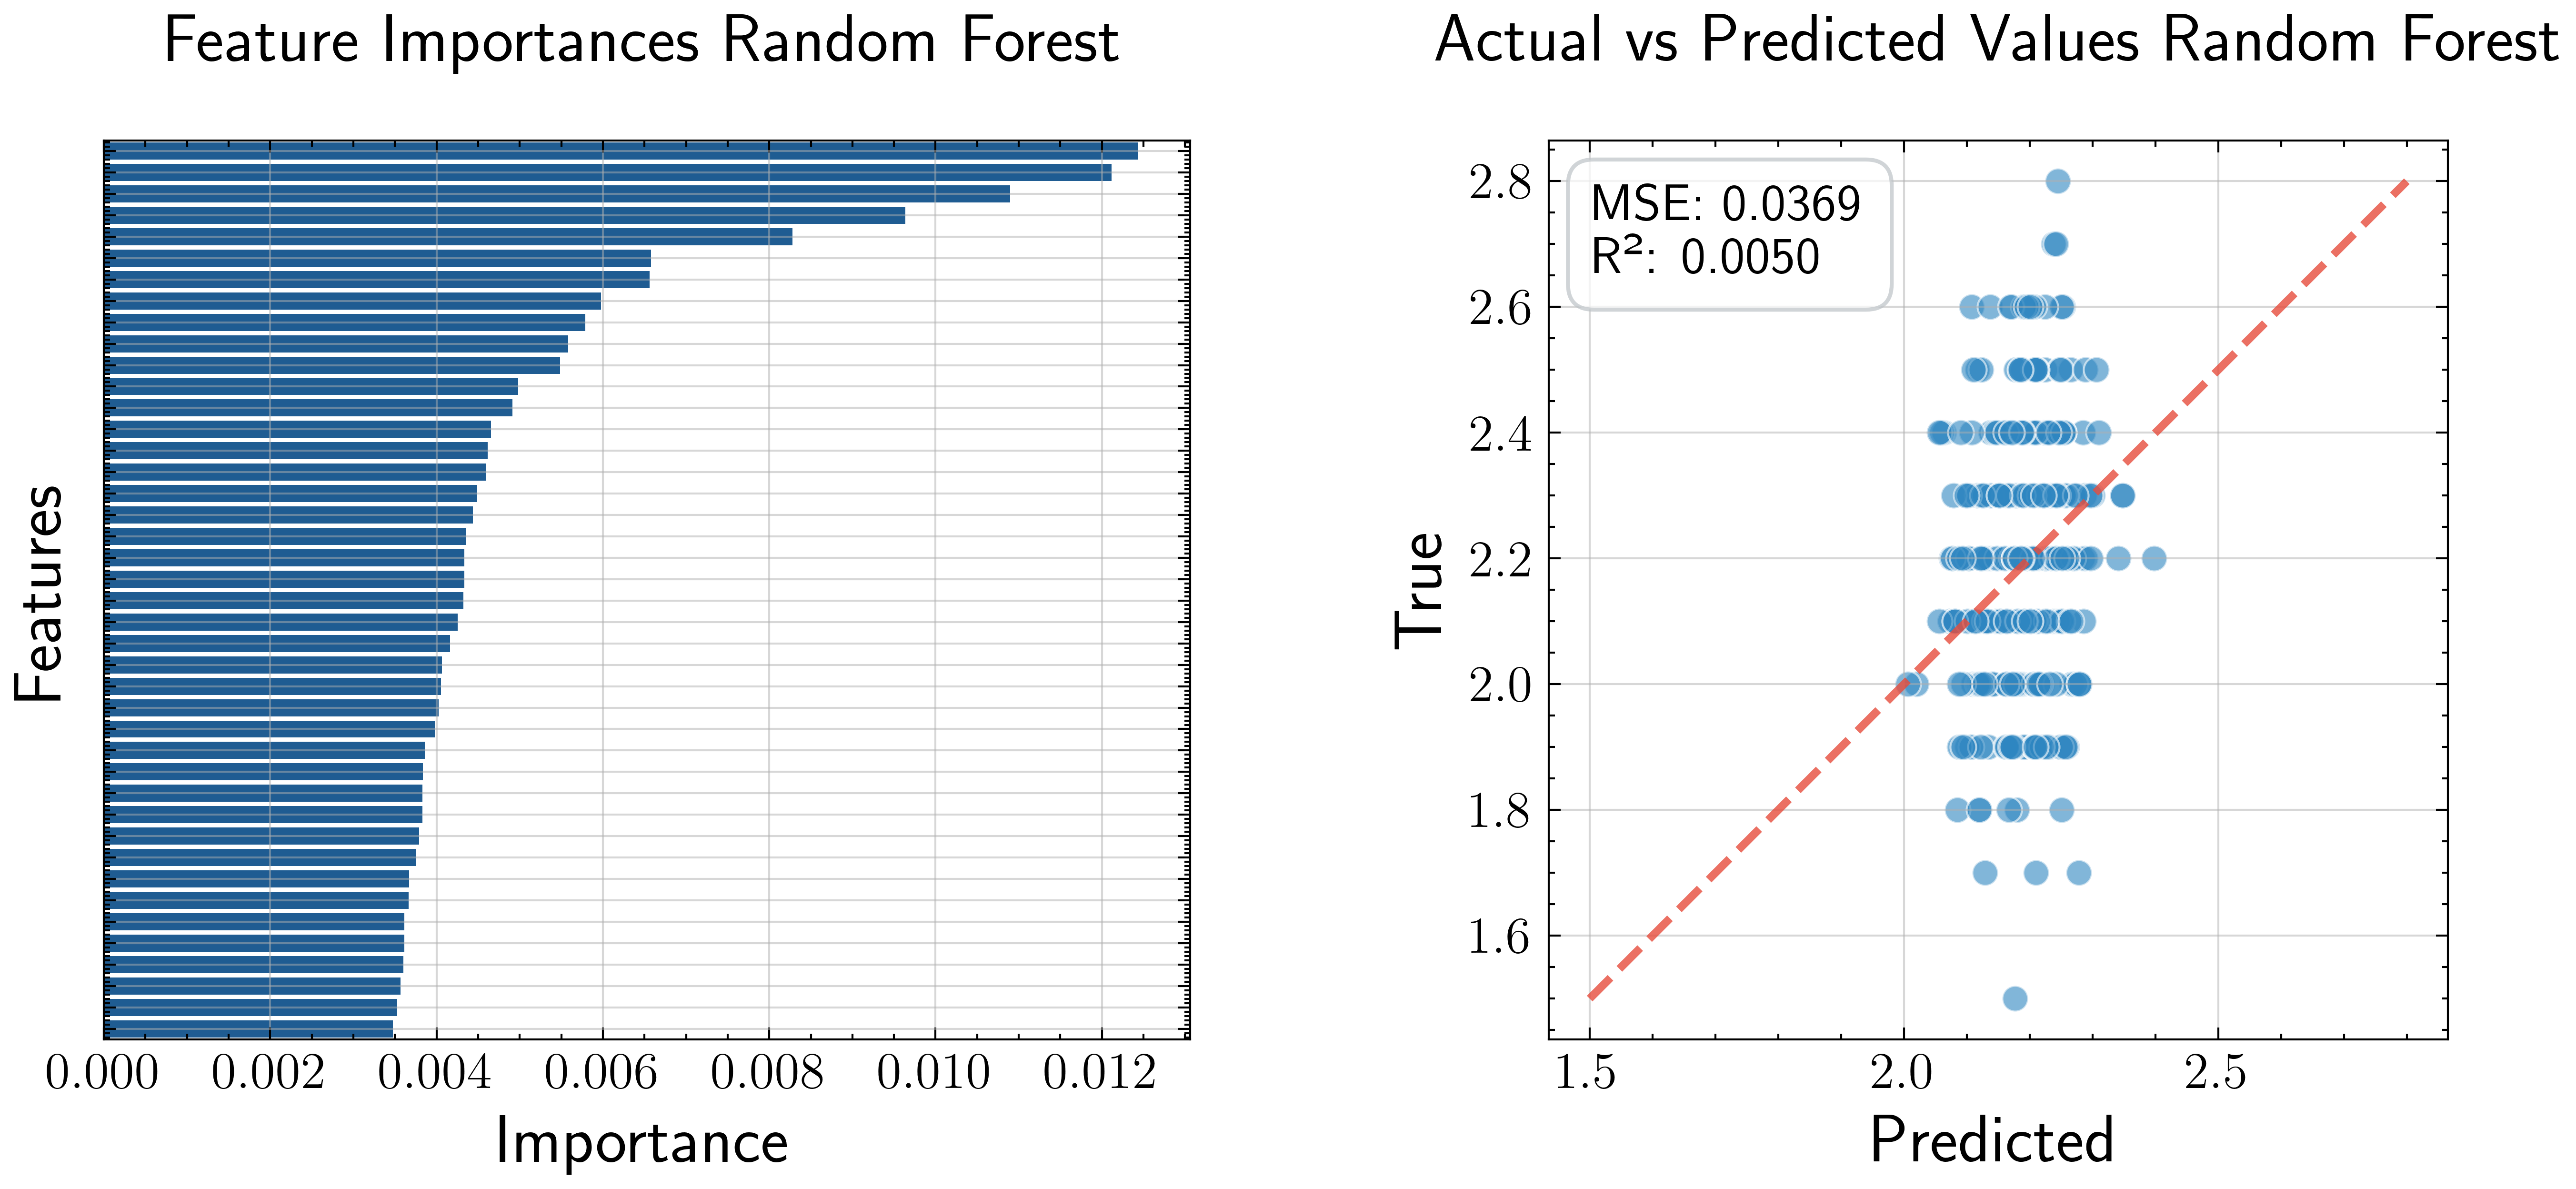

In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
score_metric = r2_score
SCORE_METRIC = 'test_r2'

from src.visuals import CustomVisualizer

for y_tr, y_te in zip([y_k_tr, y_c_tr], [y_k_te, y_c_te]):
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    rf.fit(Xf_tr, y_tr)
    y_pred = rf.predict(Xf_te)
    test_score = score_metric(y_te, y_pred)
    print(f"\t{SCORE_METRIC}: {test_score:.4f}")

    cvi = CustomVisualizer(rf, "Random Forest")
    fig, axes = cvi.create_subplot_grid()
    cvi.plot_feature_importance(ax=axes[0, 0])
    cvi.plot_actual_vs_predicted((Xf_te.detach().numpy(), y_te.detach().numpy()), ax=axes[0, 1])
    plt.show()